## Inferece Code

##### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()
ROOT_DIR = os.path.normpath(ROOT_DIR)
print("Working Dir: ", ROOT_DIR)
DATASET_DIR = os.path.join(ROOT_DIR, 'Datasets/logoDetector/')
DATASET_DIR = os.path.normpath(DATASET_DIR)
print("Dataset Dir: ", DATASET_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "LogoDetectorModel/preTrainedModel/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "LogoDetectorModel/trainingLogs/sewez20240618T0707/trainingLogs")


Working Dir:  /content
Dataset Dir:  /content/Datasets/logoDetector


##### Load configs and model

In [2]:
class TrainingConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "sewez"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + sewez_tshirt, sewez_tshirt_logo, sewez_tshirt_brand

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    # Training Learning Rate
    LEARNING_RATE = 0.001
class InferenceConfig(TrainingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
model_path = os.path.join(ROOT_DIR, 'LogoDetectorModel/trainingLogs/mask_rcnn_sewez_0300.h5')


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
model.load_weights(model_path, by_name=True,exclude=[
                    "mrcnn_class_logits", "mrcnn_bbox_fc",
                    "mrcnn_bbox", "mrcnn_mask"])



Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/LogoDetectorModel/trainingLogs/mask_rcnn_sewez_0300.h5


In [3]:
class TrainingDataset(utils.Dataset):

    def load_training_dataset(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("sewez", 1, "sewez_tshirt")
        self.add_class("sewez", 2, "sewez_tshirt_logo")
        self.add_class("sewez", 3, "sewez_tshirt_brand")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        annotations = json.load(open(os.path.join(dataset_dir, "annotation.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # iterate names
            objects = [s['region_attributes']['names'] for s in a['regions']]
            name_dict = {"sewez_tshirt": 1, "sewez_tshirt_logo": 2, "sewez_tshirt_brand": 3}
            num_ids = [name_dict[a] for a in objects]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "sewez",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "sewez":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "sewez":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [4]:
# Training dataset.
dataset_train = TrainingDataset()
dataset_train.load_training_dataset(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = TrainingDataset()
dataset_val.load_training_dataset(DATASET_DIR, "val")
dataset_val.prepare()

##### Run Inference

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 2667.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:  185.00000  max:  867.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8
[[250 472 277 554]
 [354 466 439 573]
 [204 185 867 845]]


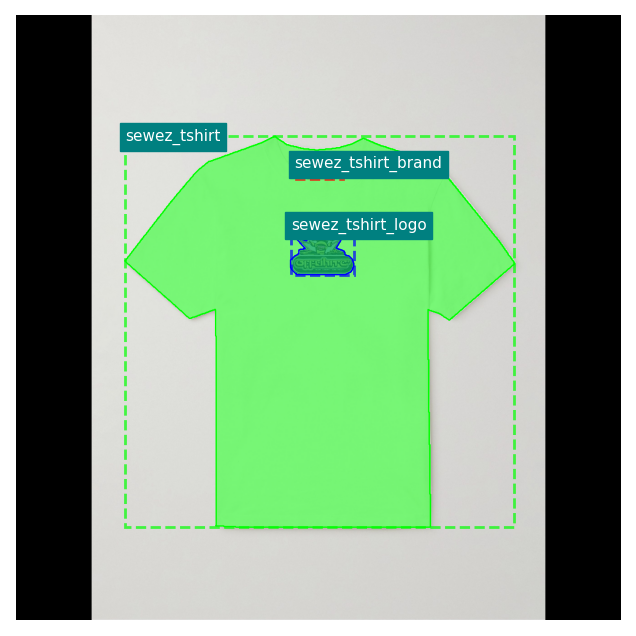

In [5]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print(gt_bbox)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

In [ ]:

import skimage
real_test_dir = os.path.join(ROOT_DIR, 'Datasets/logoDetector/test')
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

image_paths = (image_paths[0],)

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    detection_result = []
    for rows, class_id in enumerate(r['class_ids']):
        detection_id = r['class_ids'][rows]
        detection_score = r['scores'][rows]
        detection_rois = r['rois'][rows].tolist()
        maskArea = np.sum(r['masks'][:,:,rows])
        y1, x1, y2, x2 = r['rois'][rows]
        length = y2 - y1
        width = x2 - x1
        boxDimension = {
            "x": width,
            "y": length,
            "area": length * width
            }
        detection_result.append({
            detection_id:{
                "score": detection_score,
                "maskArea": maskArea,
                "boxDimension": boxDimension
            }
        })
    
    print("data", detection_result)

pricelist = {
    "A7": {
        "price": 1000,
        "dimension": {
            "x": 74,
            "y": 105,
            "area": 7785
        }
    },
    "A6": {
        "price": 2500,
        "dimension": {
            "x": 105,
            "y": 148,
            "area": 15540
        }
    },
    "A5": {
        "price": 5000,
        "dimension": {
            "x": 148,
            "y": 210,
            "area": 31080
        }
    },
    "A4": {
        "price": 10000,
        "dimension": {
            "x": 210,
            "y": 297,
            "area": 62370
        }
    },
    "A3": {
        "price": 20000,
        "dimension": {
            "x": 297,
            "y": 420,
            "area": 124740
        }
    },
    "A2": {
        "price": 30000,
        "dimension": {
            "x": 420,
            "y": 594,
            "area": 249480
        }
    }
}

def calculatePrice(detectionData, priceList):
    # hitung panjang logo relatif terhadap panjang kaos
    panjangKaos = 73
    
